In [69]:
from math import ceil, log, floor
from pathlib import Path
import pandas as pd
import numpy as np
from random import randint
from sys import getsizeof
from collections.abc import Generator, Callable
from collections import defaultdict

What data do I want to retrieve from all the files?

Looping through all the files, I can aggregate data from each file.
Each row has a bike ID which gives it a distinctive quality.
Values are:
   - Lat, Lng pairs for start and end
   - Starting and ending datetime
Categories are:
   - Bike type (Electric: True, Classic: False)
   - Member type (Member: True, Casual: False)
   - Stating and ending station name or float ID

Potential routes are:
   - Create storage 

In [70]:
dir_main = Path('/Users/neelagarwal/Desktop/CITIBike Data/')
dir_nyc = dir_main / 'NYC'
dir_jersey = dir_main / 'Jersey'

def iter_subfiles(parent: Path, year: int):
    dir_year = parent / f'{year}'

    if parent.stem == 'NYC':
        for dir_month in sorted(dir_year.iterdir()):
            dir_month: Path
            if dir_month.is_dir():
                for csv in sorted(dir_month.iterdir()):
                    csv: Path
                    if csv.is_file() and csv.suffix == '.csv':
                        yield csv.resolve()
                        
    elif parent.stem == 'Jersey':
        for csv in sorted(dir_year.iterdir()):
            csv: Path
            if csv.is_file() and csv.suffix == '.csv':
                yield csv.resolve()

def csv_generator(parent, year):
    for file in iter_subfiles(parent, year):
        yield pd.read_csv(file, low_memory = False), file

def csv_to_df(parent: Path, year: int, selected_file_num: int | None = None) -> Generator[pd.DataFrame] | pd.DataFrame | str:
    if selected_file_num is None:
        return csv_generator(parent, year)
    elif selected_file_num is not None:
        for num, file in enumerate(iter_subfiles(parent, year)):
            if num == selected_file_num:
                return pd.read_csv(file, low_memory = False), file


def generate_randint(start: int, stop: int):
    while True:
        yield randint(start, stop)

random_int = generate_randint(0, 2)

def get_all_columns(parent: Path, years: list[int]):
    all_cols = [csv_to_df(parent, year, next(random_int), just_headers = True) for year in years]
    return [(list(cols) if cols else None) for cols in all_cols]

def digits_in_words(digits: int):
    term = str(len(str(digits)))
    stmt_map = {
        '0': 'None'
        ,'1': 'Ones'
        ,'2': 'Tens'
        ,'3': 'Hundreds'
        ,'4': 'Thousands'
        ,'5': 'Tens of thousands'
        ,'6': 'Hundreds of thousands'
        ,'7': 'Millions'
        ,'8': 'Tens of millions'
        ,'9': 'Hundreds of millions'
        ,'10': 'Billions'
        ,'11': 'Tens of billions'
        ,'12': 'Hundreds of billions'
        ,'13': 'Trillions'
        ,'14': 'Tens of trillions'
        ,'15': 'Hundreds of trillions'
    }
    return stmt_map.get(term, 'None')

def convert_size(size_bytes):
    if size_bytes == 0:
        return '0B'
    size_name = ('B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB')
    i = int(floor(log(size_bytes, 1024)))
    p = 1024**i
    s = round(size_bytes / p, 2)
    return '%s %s' % (s, size_name[i])

def size_stmt_from_size(size: int):
    print(
        f'Bytes: {size}\n'
        f'Digits: {digits_in_words(size)}\n'
        f'Simplified: {convert_size(size)}'
    )
    return size

def size_stmt_delta(size: int):
    print('*DELTA SIZE*')
    size_stmt_from_size(size)
    return None

def size_stmt_from_df(df: pd.DataFrame):
    size = getsizeof(df)
    size_stmt_from_size(size)
    return size

def add_to_csv(path: Path, data: list | tuple, time_period: str | int) -> None:
    time_period = str(time_period)
    if path.exists():
        df = pd.read_csv(path, low_memory = False)
        if time_period not in df.columns:
            df[time_period] = data
        else:
            raise RuntimeError('Time period already exists in this dataframe.')
    else:
        df = pd.DataFrame({time_period: data})
    df.to_csv(path, header = True, index = False)
    return None

In [71]:
# test_df, file = csv_to_df(dir_nyc, 2024, 0)

In [72]:
def haversine_vectorized(lat1: pd.Series, lng1: pd.Series, lat2: pd.Series, lng2: pd.Series, unit = 'km' or 'mi') -> pd.Series:
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])
    delta_lat = lat2 - lat1
    delta_lng = lng2 - lng1
    a = (np.sin(delta_lat / 2.0)) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lng / 2.0)) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    if unit == 'km':
        R = 6371
    elif unit == 'mi':
        R = 3959
    result: pd.Series
    result = R * c
    return result

In [73]:
class Features:
    def __init__(self, df: pd.DataFrame, file: Path):
        self.file = file
        self.dt_from_dir()
        self.main_df = df.copy()
        self.station_csv = Path('station_data.csv')
        self.field_variations().value_mapping()
        self.clean_df().add_calculations()
        self.extract_and_normalize_stations()
    
    def dt_from_dir(self):
        path_components = self.file.parent.parts
        _month = path_components[-1]
        month = str().join(filter(str.isalpha, _month))
        year = path_components[-2]
        self.month_year = f'{year}_{month}'
        return self

    def field_variations(self):
        self.fields = ['ride_id', 'if_electric_bike'
            ,'start_dt', 'end_dt'
            ,'start_station', 'end_station'
            ,'start_id', 'end_id'
            ,'start_lat', 'start_lng'
            ,'end_lat', 'end_lng'
            ,'if_member'
        ]
        self.col_name_map = {
            'bikeid':  'ride_id'
            ,'bike id': 'ride_id'

            ,'rideable_type': 'if_electric_bike'

            ,'started_at': 'start_dt'
            ,'starttime': 'start_dt'
            ,'start time': 'start_dt'

            ,'ended_at': 'end_dt'
            ,'stoptime': 'end_dt'
            ,'stop time': 'end_dt'

            ,'start_station_name': 'start_station'
            ,'start station name': 'start_station'

            ,'end_station_name': 'end_station'
            ,'end station name': 'end_station'

            ,'start_station_id': 'start_id'
            ,'start station id': 'start_id'

            ,'end_station_id': 'end_id'
            ,'end station id': 'end_id'

            ,'start station latitude': 'start_lat'
            ,'start station longitude': 'start_lng'

            ,'end station latitude': 'end_lat'
            ,'end station longitude': 'end_lng'

            ,'member_casual': 'if_member'
            ,'usertype': 'if_member'
            ,'user type': 'if_member'
        }
        return self
    
    def value_mapping(self):
        self.bike_type_map = {'classic_bike': False, 'electric_bike': True}
        self.membership_map = {
            'casual': False, 'member': True,
            'Customer': False, 'Subscriber': True
        }
        return self
    
    def clean_df(self):
        self.main_df.dropna(how = 'any', inplace = True)
        self.main_df.columns = [col.lower() for col in self.main_df.columns]
        self.main_df.rename(columns = self.col_name_map, inplace = True)
        if 'if_electric_bike' in list(self.main_df.columns):
            self.main_df['if_electric_bike'] = self.main_df['if_electric_bike'].map(self.bike_type_map).astype(bool)
        else:
            self.main_df['if_electric_bike'] = False
        self.main_df['if_member'] = self.main_df['if_member'].map(self.membership_map).astype(bool)

        self.main_df['start_dt'] = pd.to_datetime(self.main_df['start_dt'])
        self.main_df['end_dt'] = pd.to_datetime(self.main_df['end_dt'])

        self.main_df = self.main_df[self.fields].copy()
        return self

    def add_calculations(self):
        self.main_df['duration_sec'] = pd.to_timedelta(self.main_df['end_dt'] - self.main_df['start_dt']).dt.total_seconds()
        unit = 'mi'
        self.main_df[f'distance_{unit}'] = haversine_vectorized(
            self.main_df['start_lat']
            ,self.main_df['start_lng']
            ,self.main_df['end_lat']
            ,self.main_df['end_lng']
            ,unit
        ).round(4)
        return self
    
    def extract_and_normalize_stations(self):
        new_stations = pd.concat([self.main_df['start_station'], self.main_df['end_station']], axis = 0).drop_duplicates(keep = 'first')

        if self.station_csv.exists():
            station_data = pd.read_csv(self.station_csv)
            stations = pd.concat([station_data['name'], new_stations], axis = 0).drop_duplicates(keep = 'first')
        else:
            stations = new_stations
        stations = stations.to_list()

        station_ids = list(range(1, len(stations) + 1))
        id_mapping = {str(station): id for id, station in zip(station_ids, stations)}

        self.main_df['start_station'] = self.main_df['start_station'].map(id_mapping)
        self.main_df['end_station'] = self.main_df['end_station'].map(id_mapping)
        self.main_df.drop(columns = ['start_id', 'end_id'], inplace = True)
        self.station_table = pd.DataFrame({'id': station_ids, 'name': stations})
        self.station_table.to_csv(self.station_csv, header = True, index = False)
        return self
    
    def merged_stations_table(self, df: pd.DataFrame | pd.Series | None = None) -> pd.DataFrame:
        if df is not None:
            if isinstance(df, pd.DataFrame):
                pass
            elif isinstance(df, pd.Series):
                df = pd.DataFrame(df)
        elif df is None:
            df = self.main_df

        if 'start_station' in df.columns:
            df = df.merge(
                self.station_table, how = 'inner', left_on = 'start_station', right_on = 'id'
            ).drop(columns = ['start_station', 'id']
            ).rename(columns = {'name': 'start_station'}
            ).copy()
        if 'end_station' in df.columns:
            df = df.merge(
                self.station_table, how = 'inner', left_on = 'end_station', right_on = 'id'
            ).drop(columns = ['end_station', 'id']
            ).rename(columns = {'name': 'end_station'}
            ).copy()
        if 'total_distances' in df.columns or 'station_freq' in df.columns:
            df = df.merge(
                self.station_table, how = 'inner', left_index = True, right_on = 'id'
            ).drop(columns = ['id']
            ).rename(columns = {'name': 'station'}
            ).set_index('station', drop = True
            ).copy()
        return df

    def get_by_attr(self, df: str):
        return self.__getattribute__(df)
    
    def get_by_method(self, method: str):
        return getattr(self, method)

    def get_distance_per_station(self, aggr_func: Callable[[], pd.DataFrame] = pd.Series.sum):
        df = self.main_df
        distance_per_startStation = pd.DataFrame(df.groupby('start_station')['distance_mi'].agg(aggr_func))
        distance_per_endStation = pd.DataFrame(df.groupby('end_station')['distance_mi'].agg(aggr_func))
        distance_per_station = distance_per_startStation.merge(distance_per_endStation, how = 'inner', left_index = True, right_index = True)
        distance_per_station['distance_aggr'] = distance_per_station['distance_mi_x'] + distance_per_station['distance_mi_y']
        distance_per_station = distance_per_station['distance_aggr']
        return distance_per_station
    
    def get_duration_per_station(self, aggr_func: Callable[[], pd.DataFrame] = pd.Series.sum):
        df = self.main_df
        duration_per_startStation = pd.DataFrame(df.groupby('start_station')['duration_sec'].agg(aggr_func))
        duration_per_endStation = pd.DataFrame(df.groupby('end_station')['duration_sec'].agg(aggr_func))
        duration_per_station = duration_per_startStation.merge(duration_per_endStation, how = 'inner', left_index = True, right_index = True)
        duration_per_station['duration_aggr'] = duration_per_station['duration_sec_x'] + duration_per_station['duration_sec_y']
        duration_per_station = duration_per_station['duration_aggr']
        return duration_per_station
    
    def get_station_freq(self):
        df = self.main_df
        start_station_view = df.groupby('start_station')['ride_id'].count()
        end_station_view = df.groupby('end_station')['ride_id'].count()
        view = pd.concat([start_station_view, end_station_view], axis = 1)
        view.fillna(0, inplace = True)
        view['station_freq'] = view.iloc[:, 0] + view.iloc[:, 1]
        station_freq = view['station_freq'].astype(int).copy()
        return station_freq
    
    def get_counts_per_hour(self):
        df = self.main_df
        counts_per_hour = df.groupby(df['start_dt'].dt.hour)['ride_id'].count()
        counts_per_hour.name = 'Counts'
        counts_per_hour.index.name = 'Hour'
        return counts_per_hour
    
    def get_counts_per_day(self):
        df = self.main_df
        counts_per_day = df.groupby(df['start_dt'].dt.day)['ride_id'].count()
        counts_per_day.name = 'Counts'
        counts_per_day.index.name = 'Day'
        return counts_per_day

# 
#
#

def build_counts_by_day(parent_dir: Path):
    hour_bins = defaultdict(lambda: pd.Series(dtype = 'int64'))
    day_bins = defaultdict(lambda: pd.Series(dtype = 'int64'))
    years = list(range(2013, 2026))
    for year in years:
        for obj_iter in csv_to_df(parent_dir, year):
            curr_feats = Features(*obj_iter)
            hour_counts = curr_feats.get_counts_per_hour()
            day_counts = curr_feats.get_counts_per_day()
            month_key = curr_feats.month_year
            print(f'Looping for: {month_key}')
            hour_bins[month_key] = hour_bins[month_key].add(hour_counts, fill_value = 0).astype('int64')
            day_bins[month_key] = day_bins[month_key].add(day_counts, fill_value = 0).astype('int64')
    hour_df = pd.DataFrame(hour_bins).reindex(range(0, 24))
    day_df = pd.DataFrame(day_bins).reindex(range(1, 32))
    cols = pd.to_datetime(day_df.columns, format="%Y_%b")
    for ts in cols:
        day_df.loc[ts.days_in_month + 1 :, ts.strftime("%Y_%b")] = pd.NA
    return hour_df, day_df


def build_agg_df(parent_dir: Path, df_choice: str | None = None, method_choice: str | None = None):
    aggr_df = pd.DataFrame()
    years = list(range(2013, 2026))
    for year in years:
        for df_iter in csv_to_df(parent_dir, year):
            feats = Features(*df_iter)
            if aggr_df.shape == (0, 0):
                if df_choice:
                    aggr_df = feats.get_by_attr(df_choice)
                elif method_choice:
                    aggr_df = feats.get_by_method(method_choice)
            if df_choice:
                series: pd.Series = feats.get_by_attr(df_choice)
                series.name = feats.month_year
                aggr_df = pd.concat([aggr_df, series], axis = 0)
            elif method_choice:
                series: pd.Series = feats.get_by_method(method_choice)
                series.name = feats.month_year
                aggr_df = pd.concat([aggr_df, series], axis = 0)
    return aggr_df

In [74]:
hourly_counts_df, daily_counts_df = build_counts_by_day(dir_nyc)

Looping for: 2013_Jun
Looping for: 2013_Jul
Looping for: 2013_Aug
Looping for: 2013_Aug
Looping for: 2013_Sep
Looping for: 2013_Sep
Looping for: 2013_Oct
Looping for: 2013_Oct
Looping for: 2013_Nov
Looping for: 2013_Dec
Looping for: 2014_Jan
Looping for: 2014_Feb
Looping for: 2014_Mar
Looping for: 2014_Apr
Looping for: 2014_May
Looping for: 2014_Jun
Looping for: 2014_Jul
Looping for: 2014_Aug
Looping for: 2014_Sep
Looping for: 2014_Oct
Looping for: 2014_Nov
Looping for: 2014_Dec
Looping for: 2015_Jan
Looping for: 2015_Feb
Looping for: 2015_Mar
Looping for: 2015_Apr
Looping for: 2015_May
Looping for: 2015_Jun
Looping for: 2015_Jul
Looping for: 2015_Jul
Looping for: 2015_Aug
Looping for: 2015_Aug
Looping for: 2015_Sep
Looping for: 2015_Sep
Looping for: 2015_Oct
Looping for: 2015_Oct
Looping for: 2015_Nov
Looping for: 2015_Dec
Looping for: 2016_Jan
Looping for: 2016_Feb
Looping for: 2016_Mar
Looping for: 2016_Apr
Looping for: 2016_Apr
Looping for: 2016_May
Looping for: 2016_May
Looping fo

In [80]:
daily_counts_df.to_csv('daily_ride_counts.csv', header = True, index = True)

In [81]:
hourly_counts_df.to_csv('hourly_ride_counts.csv', header = True, index = True)

In [7]:
feats = Features(*csv_to_df(dir_nyc, 2024, 0))
# feats.get_distance_per_station()

In [ ]:
test_counts = feats.get_counts_per_day()

In [20]:
test_counts.name = feats.month_year

In [23]:
feats2 = Features(*csv_to_df(dir_nyc, 2024, 1))
test_counts2 = feats2.counts_per_day
test_counts2.name = feats2.month_year

In [24]:
test_counts2

Day
1     87515
2     68529
3     72181
4     66161
5     76957
6     81931
7     89503
8     94757
9     96995
10    94330
11    76810
12    83630
13    31930
14    70756
15    75348
16    75292
17    37999
18    46325
19    58333
20    68332
21    74192
22    71005
23    75994
24    71946
25    57004
26    82934
27    78188
28    67402
29    83515
31      195
Name: 2024_Feb, dtype: int64

In [ ]:
if test_counts2.name == test_counts.name:
    test_counts += test_counts2
else:
    counts = pd.concat([test_counts, test_counts2], axis = 1)

,2024_Jan,2024_Feb
Day,,
1,47031,87515.0
2,67838,68529.0
3,76213,72181.0
4,77273,66161.0
5,72233,76957.0
6,43133,81931.0
7,35575,89503.0
8,78247,94757.0
9,42890,96995.0


In [13]:
feats.station_freq.sort_values(ascending = False)

1041    16629
1376    13170
1010    12689
273     12072
1493    11808
        ...  
2384        1
2376        1
2148        1
2372        1
2410        1
Name: station_freq, Length: 2167, dtype: int64

In [43]:
feats.station_freq

1        863
2       1643
3       5713
4        549
5        462
        ... 
2384       1
2391       2
2393      17
2408       4
2410       1
Name: station_freq, Length: 2167, dtype: int64

In [74]:
feats.merged_stations_table(feats.get_station_freq()).sort_values('station_freq', ascending = False)
# pd.DataFrame(distances)

,station_freq
station,
Pershing Square North,19491
8 Ave & W 31 St,15001
Broadway & E 22 St,13715
W 21 St & 6 Ave,13594
8 Ave & W 33 St,12008
...,...
Washington St,2
Prototype Lab Motivate Headquarters,2
NYCBS Depot - RIS,1


In [103]:
test = feats.main_df
test.loc[test['if_electric_bike'] == True].sort_values('start_dt')

,ride_id,if_electric_bike,start_dt,end_dt,start_station,end_station,start_lat,start_lng,end_lat,end_lng,if_member,duration_sec,distance_mi
636723,36EEF8E63CF3300B,True,2019-01-19 18:24:31.851,2020-01-24 10:00:25.259,110,1076,40.782939,-73.978652,40.794566,-73.936254,False,3.193775e+07,2.3591
539470,593DC5F0BF792584,True,2020-01-01 00:10:10.625,2020-01-01 00:13:36.586,1759,1520,40.762699,-73.993012,40.768254,-73.988639,True,2.059610e+02,0.4469
777233,6711A4D61DD7B324,True,2020-01-01 11:17:51.083,2020-01-01 11:51:45.026,2227,1143,40.724537,-73.981854,40.723684,-73.975748,True,2.033943e+03,0.3251
317872,676B55BBFB988A60,True,2020-01-01 12:03:30.581,2020-01-01 12:56:39.258,1143,249,40.723684,-73.975748,40.709601,-74.006551,True,3.188677e+03,1.8840
578068,5179CFB1EF58854B,True,2020-01-01 13:07:23.307,2020-01-01 13:18:25.709,249,636,40.709601,-74.006551,40.707065,-74.007319,True,6.624020e+02,0.1798
...,...,...,...,...,...,...,...,...,...,...,...,...,...
874345,21A943C86AF464B4,True,2020-01-31 14:17:31.359,2020-01-31 14:23:16.624,1298,1620,40.759711,-73.974023,40.762288,-73.983362,True,3.452650e+02,0.5202
280676,4D89BEABE8DEC4B6,True,2020-01-31 14:29:29.524,2020-01-31 14:43:15.697,1620,2168,40.762288,-73.983362,40.751551,-73.993934,True,8.261730e+02,0.9255
269445,4B0894768BEFB2DA,True,2020-01-31 16:04:23.406,2020-01-31 16:22:19.116,272,901,40.742754,-74.007474,40.715595,-73.987030,True,1.075710e+03,2.1605
668371,326E25D84F78B27C,True,2020-01-31 17:02:58.790,2020-01-31 17:14:08.751,901,260,40.715595,-73.987030,40.735877,-73.982050,True,6.699610e+02,1.4255


In [50]:
6999760.846 / 60 / 60 / 24 / 7

11.573678647486773

In [65]:
df = pd.DataFrame()
files = range(4, 7)
for file in files:
    raw_df = csv_to_df(dir_nyc, 2025, file)
    feats = Features(raw_df)
    df = pd.concat([df, feats.main_df], axis = 0)

In [71]:
# df.to_csv(Path('test_csv.csv'), header = True, index = False)
df = pd.read_csv(Path('test_csv.csv'))

In [ ]:
feats = Features(df2)
feats.main_df

Bytes: 40466702
Digits: Tens of millions
Simplified: 38.59 MB


40466702

In [37]:
feats.main_df.groupby('if_member')['ride_id'].count()

if_member
False    135874
True     827615
Name: ride_id, dtype: int64

In [38]:
feats.main_df.sort_values('duration_sec', ascending = False).head()

,ride_id,if_electric_bike,start_station,end_station,if_member,duration_sec,distance_mi
286461,15709,False,1153,2181,False,21541.0,0.9702
294577,19415,False,212,1503,True,21518.0,0.7236
97406,18733,False,2176,2180,False,21511.0,2.9559
33068,19058,False,1271,14,False,21507.0,0.5313
234569,20558,False,1503,1503,False,21503.0,0.0000


In [45]:
s = feats.merged_stations_table(feats.main_df.sort_values('distance_mi', ascending = False).head(20))

In [46]:
_ = size_stmt_from_df(s)

Bytes: 3508
Digits: Thousands
Simplified: 3.43 KB


<Axes: >

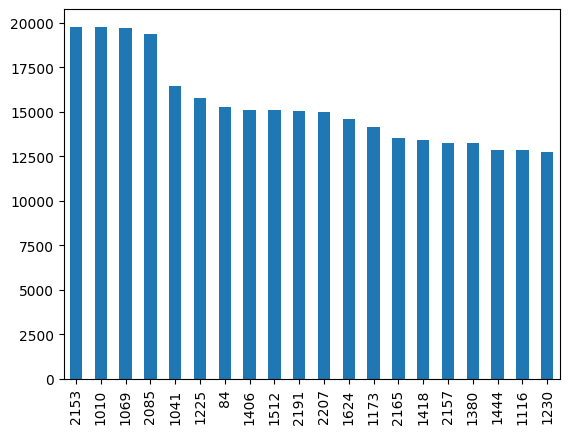

In [47]:
save = feats.get_station_freq()
save.sort_values(ascending = False).head(20).plot.bar()

In [ ]:
size_stmt_from_df(feats.main_df.drop(columns = ['ride_id']))

Bytes: 41717414
Digits: Tens of millions
Simplified: 39.78 MB


41717414

In [39]:
feats.get_distance_per_station()

1        1180.1865
2        6800.6951
3       10634.1147
4        1545.7246
5         625.5306
           ...    
2124      101.3545
2125       30.8983
2126        3.6718
2127       20.4147
2128       87.8954
Name: total_distances, Length: 2096, dtype: float64

In [ ]:
df = pd.DataFrame()

chunk_size = int(1e5)
size = df.shape[0]
num_chunks = ceil(size / chunk_size)

df_chunks = []
for i in range(num_chunks):
    chunk = df.loc[i * size : (i+1) * size]
    df_chunks.append(chunk)

In [ ]:
test_df = pd.DataFrame()

for df in df_chunks:
    test_df = pd.concat([test_df, df])

In [ ]:
test_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5511719F60A614AA,classic_bike,2023-07-10 20:07:52.959,2023-07-10 20:20:16.918,E 27 St & Park Ave S,6131.13,1 Ave & E 39 St,6303.01,40.742752,-73.984716,40.747140,-73.971130,casual
1,0747E080C54F7AAE,classic_bike,2023-07-17 15:30:30.216,2023-07-17 15:33:10.123,South St & Gouverneur Ln,4953.04,Maiden Ln & Pearl St,5065.10,40.703554,-74.006702,40.707065,-74.007319,member
2,1243D8C21B002936,classic_bike,2023-07-30 16:21:26.583,2023-07-30 16:38:17.095,South St & Gouverneur Ln,4953.04,St Marks Pl & 2 Ave,5669.10,40.703554,-74.006702,40.728419,-73.987140,member
3,82B9DB6B37D6104F,classic_bike,2023-07-31 17:22:49.480,2023-07-31 17:33:48.668,Forsyth St & Canal St,5270.07,Maiden Ln & Pearl St,5065.10,40.715815,-73.994224,40.707065,-74.007319,member
4,23E978F5180198F1,classic_bike,2023-07-11 18:25:52.841,2023-07-11 18:36:15.167,34 Ave & 45 St,6596.10,31 St & 23 Ave,7144.01,40.754795,-73.917014,40.774788,-73.912555,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
659576,832CA1B4855C70A5,electric_bike,2023-07-13 05:27:33.831,2023-07-13 05:54:28.704,Irving Ave & Harman St,4856.05,48 St & Broadway,6629.06,40.700916,-73.918112,40.755763,-73.912715,member
659577,8557BC1F7CCA1C6A,electric_bike,2023-07-11 19:06:35.962,2023-07-11 19:12:58.083,Madison St & Clinton St,5190.07,Canal St & Rutgers St,5303.08,40.712663,-73.987653,40.714275,-73.989900,member
659578,BE271830E3562BE2,electric_bike,2023-07-17 17:09:37.585,2023-07-17 17:15:17.400,N Moore St & Hudson St,5470.02,Liberty St & Broadway,5105.01,40.719961,-74.008443,40.709056,-74.010434,member
659579,90C7E9A95C19F0EA,electric_bike,2023-07-25 15:17:57.952,2023-07-25 15:21:48.394,N Moore St & Hudson St,5470.02,Liberty St & Broadway,5105.01,40.719931,-74.008355,40.709056,-74.010434,member
